# End-to-End Machine Learning Project

I'll be using the California Housing Prices dataset from the StatLib repository to predict median house prices on a given district. This dataset is based on data from the 1990 California census.

## 1. Looking at the big picture  
Using the California census data, I built a model of housing prices. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them "districts" for short.

The model will be able to learn from this data and predic the median housing price in any distric, given all the other metrics.

### Framing the Problem
I supposed that this model's output (a prediction of a district's median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine wether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.   

The district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.  
  
This is costly and time-consuming, and the estimates are off by more than 20%. This is why it is useful to train a model to predict a district's median housing price, given other data about that district. The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.  
  
This is clearly a typical supervised learning task, since I'm given labeled training examples. It is also a multiple regression problem, since the system will use multiple features to make a prediction value (it will use the district's population, the median income, etc.) It is also a univariate regression problem, since I'm only trying to predict a single value for each district. Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning do just fine.

### Selecting a Performance Measure  
RMSE works well for regression problems. It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

## 2. Gettting the data

### Download the Data

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/JosephArcila/End_to_end_ML/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
print('HOUSING_PATH: ' + HOUSING_PATH)
print('HOUSING_URL: ' + HOUSING_URL)

HOUSING_PATH: datasets\housing
HOUSING_URL: https://raw.githubusercontent.com/JosephArcila/End_to_end_ML/master/datasets/housing/housing.tgz


In [3]:
# Create a dataset/housing directory, downloads the housing.tgz file, and extracts the housing.csv file
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True) # creates the directory "datasets" and then isnide it the "housing" directory
    tgz_path = os.path.join(housing_path, "housing_path") # creates the string 'datasets\\housing\\housing_path'
    urllib.request.urlretrieve(housing_url, tgz_path) # copy the network object "housing_url" to the local file "tgz_path"
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Taking a Quick Look at the Data Structure

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 207 districts are missing the feature total_bedrooms
* All attributes are numerical, except the ocean_proximity field

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

ocean_proximity is a categorical text attribute

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


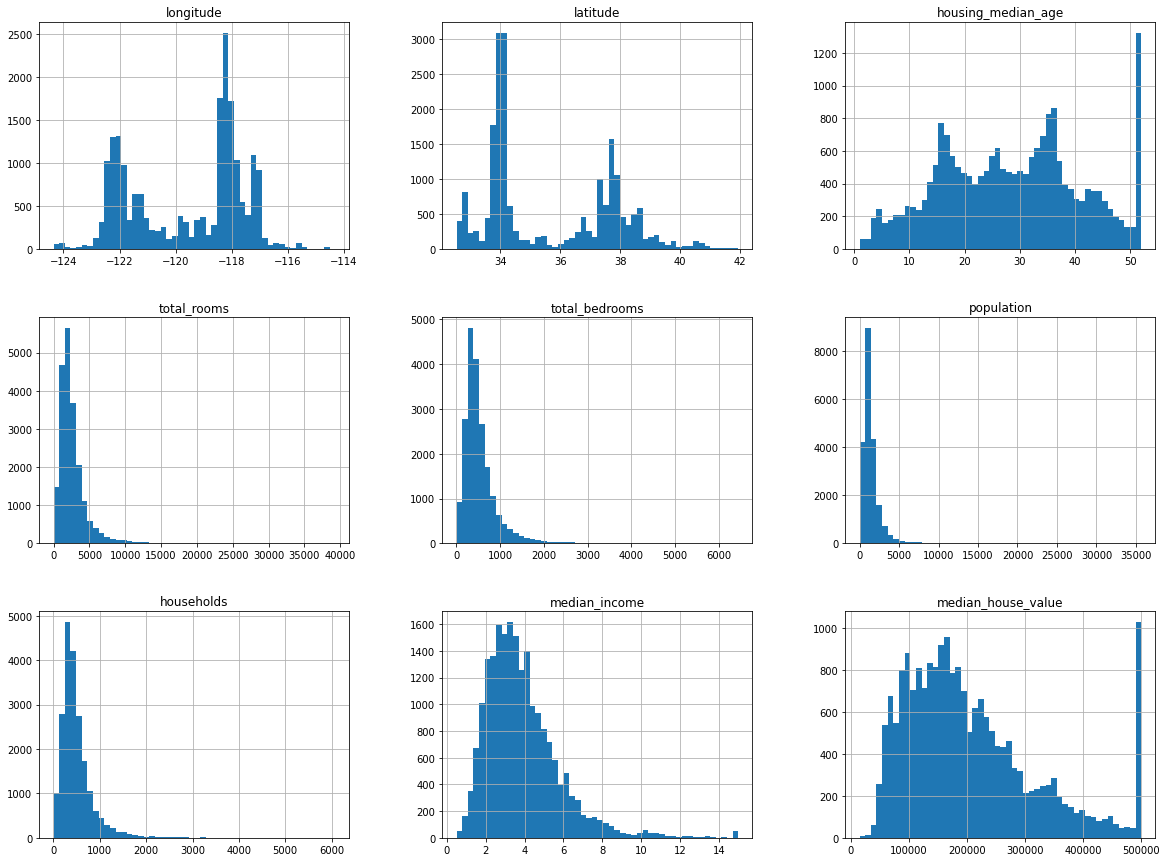

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

1. The median income attribute does not look like it is expressed in USD. So I'm going to suppose that the data has been scaled and capped at 15.01 for higher median incomes, and at 0.49) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about \\$30,000).  
2. The housing median age and the median house value where also capped. The latter may be a serious problem since it is the target attribute (labels). The Machine Learning algorithms may learn that prices never go beyond that limit.    
3. The attributes have very different scales.  
4. Many histograms are tail-heavy: they extend farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. It is needed to transform these attributes to have more bell-shaped distributions

### Considering logarithmic transformations on the tail-heavy attributes so that the data looks like normal distributed

In [12]:
import seaborn as sns
from scipy import stats
import numpy as np

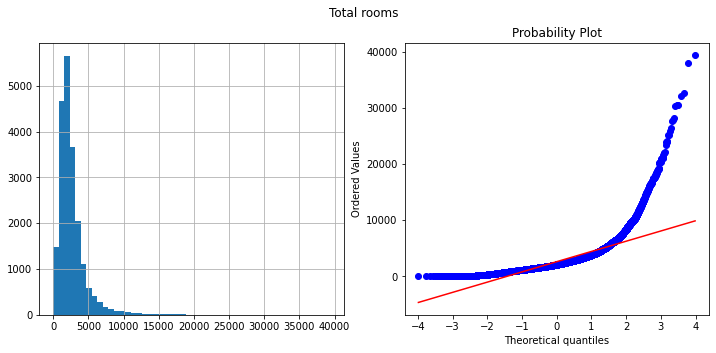

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
housing['total_rooms'].hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(housing['total_rooms'], plot=plt)

plt.suptitle("Total rooms");

total_rooms is not normal. It shows positive peakedness, and does not follow the diagonal line.

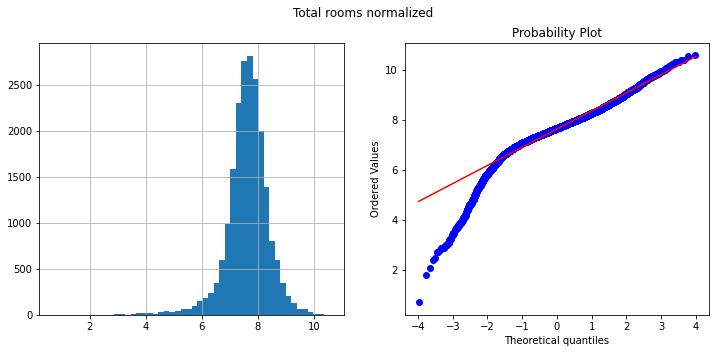

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
np.log(housing['total_rooms']).hist(bins=50)

plt.subplot(1, 2, 2)
res = stats.probplot(np.log(housing['total_rooms']), plot=plt)

plt.suptitle("Total rooms normalized");

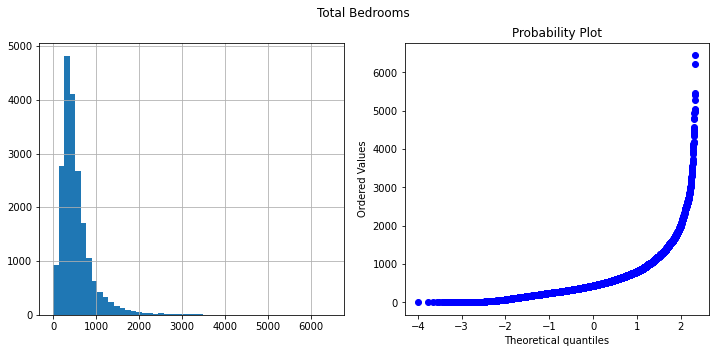

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
housing['total_bedrooms'].hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(housing['total_bedrooms'], plot=plt)

plt.suptitle("Total Bedrooms");

total_bedrooms is not normal. It shows positive peakedness, and does not follow the diagonal line.

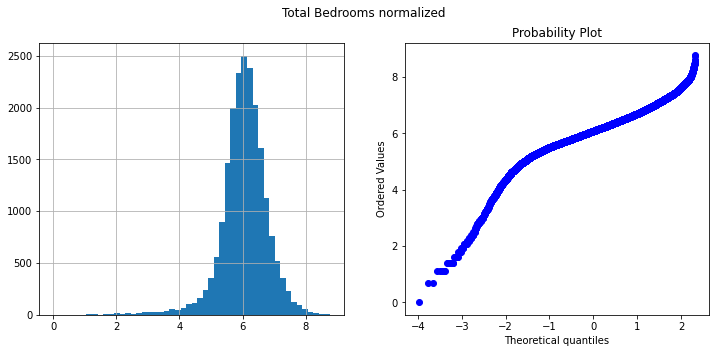

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
np.log(housing['total_bedrooms']).hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(np.log(housing['total_bedrooms']), plot=plt)

plt.suptitle("Total Bedrooms normalized");

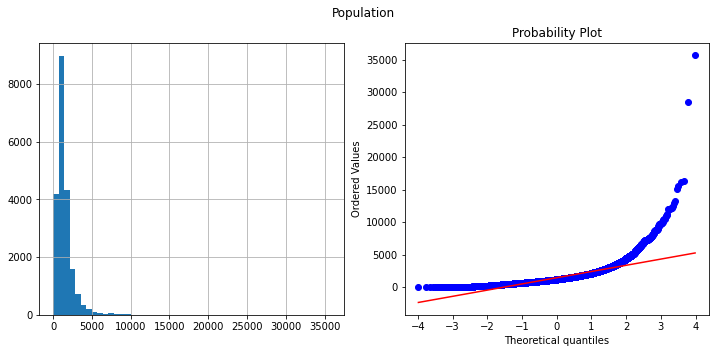

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
housing['population'].hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(housing['population'], plot=plt)

plt.suptitle("Population");

population is not normal. It shows positive peakedness, and does not follow the diagonal line.

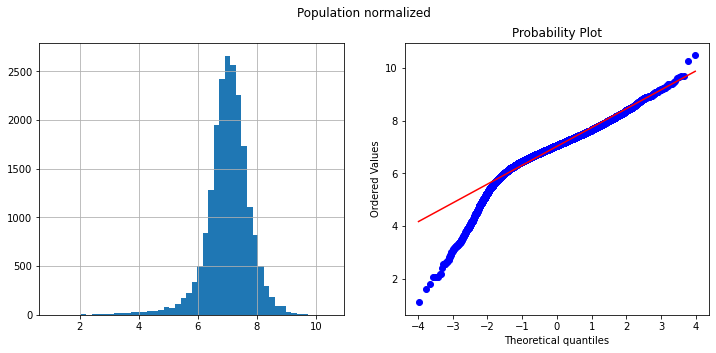

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
np.log(housing['population']).hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(np.log(housing['population']), plot=plt)

plt.suptitle("Population normalized");

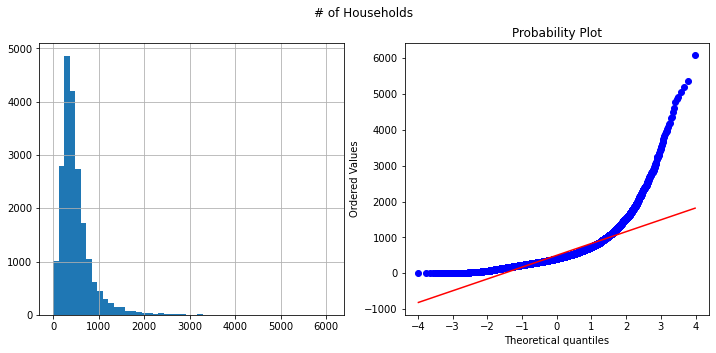

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
housing['households'].hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(housing['households'], plot=plt)

plt.suptitle("# of Households");

households is not normal. It shows positive peakedness, and does not follow the diagonal line.

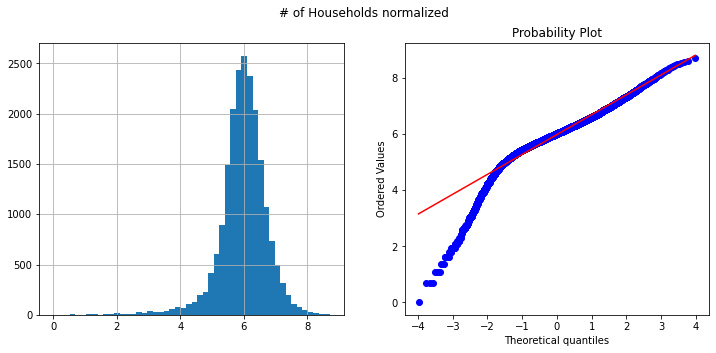

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
np.log(housing['households']).hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(np.log(housing['households']), plot=plt)

plt.suptitle("# of Households normalized");

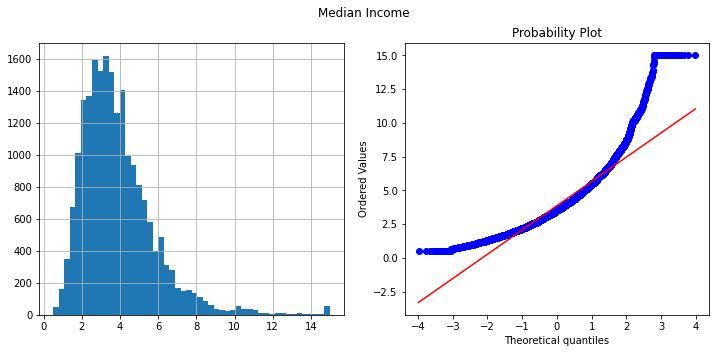

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
housing['median_income'].hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(housing['median_income'], plot=plt)

plt.suptitle("Median Income");

median_income is not normal. It shows positive peakedness, and does not follow the diagonal line.

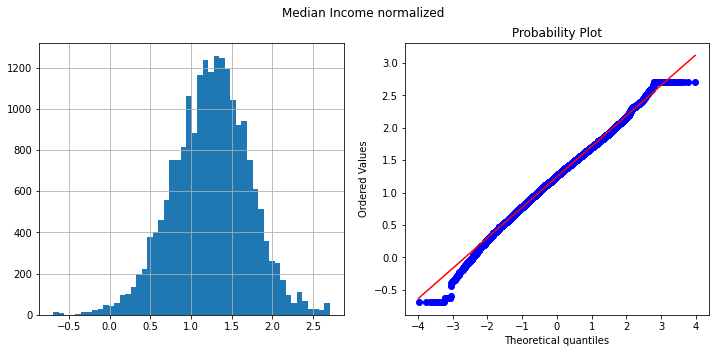

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
np.log(housing['median_income']).hist(bins=50);

plt.subplot(1, 2, 2)
res = stats.probplot(np.log(housing['median_income']), plot=plt)

plt.suptitle("Median Income normalized");

### Creating a Test Set

In [23]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [24]:
# Looking at the correlation between attributes and the target variable
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

because the median income is a very important attribute to predict median housing prices. I ensured that the test set is representative of the various categories of incomes in the whole dataset.

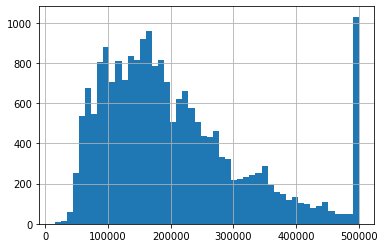

In [25]:
housing['median_house_value'].hist(bins=50)
plt.show()

Most median income values are clustered around \\$15,000 to \\$60,000, but some incomes go far beyond \\$60,000. Is important to have a sufficient number of instances in the dataset for each stratum.

In [26]:
# Creating an income category attribute.
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

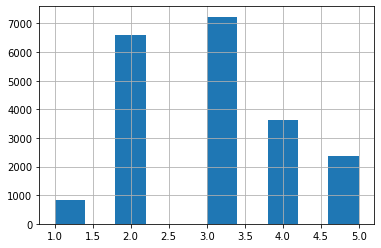

In [27]:
# Histogram of income categories
housing['income_cat'].hist();

In [28]:
# Stratified sapling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
# Removing the income_cat attribute so the data is back ot its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 3. Discovering and visualizing data to gain insights

In [30]:
# Putting the test set aside
housing = strat_train_set.copy()

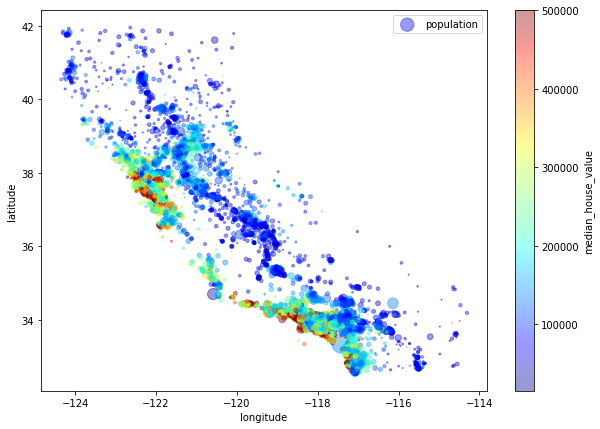

In [31]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
             s=housing['population']/100, label='population', figsize=(10,7), 
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, 
             sharex=False)
plt.legend();

It is clearly visible the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.  
  
The radius of each circle represents the district's population, and the color represents the price.  
  
This image tells that the housing prices are very much related to the location (e.g.,close to de ocean) and to the population density. 

######  Ideas to try next: Use a clustering algorithm for detecting the main cluster and for adding new features that measure the proximity to the cluster centers

### Looking for Correlations

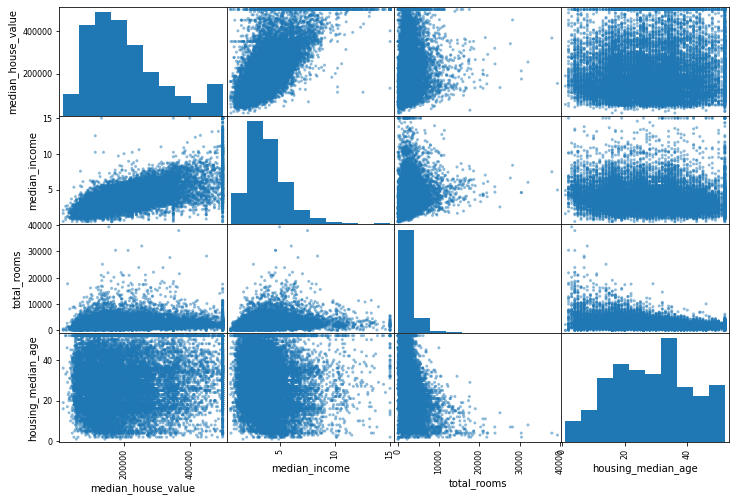

In [32]:
from pandas.plotting import scatter_matrix

promising_attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[promising_attributes], figsize=(12, 8));

The most promising attribute to predict the median house value is the median income

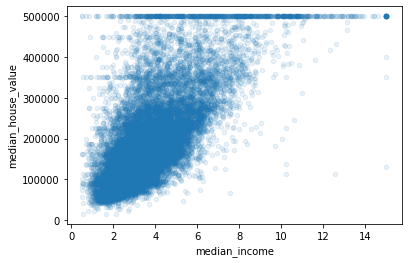

In [33]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

The correlation is very strong; there is clearly an upward trend, and the points are not too dispersed.
The price cap that was noticed earlier is clearly visible as a horizontal line at \\$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000, perhaps one around \\$280,000 and a few more below that.

###### Ideas to try next: Try removing the correspoinding districts to prevent the algorithms from learning to reproduce these data quirks

### Experimenting with Attribute Combinations
Because the total number of roms in a district is not very useful if we don't know how many households there are. We want the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful. And the population per household also seems like an interesting attribute combination to look at.

In [34]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['population_per_household'] = housing['population'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']

In [35]:
# Looking at the correlation between attributes and the target variable
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district.

## 4. Preparing the data for Machine Learning algorithms

In [36]:
# Reverting to a clean training set
housing = strat_train_set.drop('median_house_value', axis=1)
# Separating the predictors and the labels
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

In [37]:
from sklearn.impute import SimpleImputer

In [38]:
# Setting the missing values to the median
imputer = SimpleImputer(strategy='median')

In [39]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [40]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [41]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [42]:
# Using the trained imputer to transform the training set by replacing missing values with the learned medians
X = imputer.transform(housing_num)

In [43]:
# Putting back the result into a pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling Text and Categorical Attributes

In [44]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


Because this is an unordered categorical attribute, a common transformation to convert these categories from text to numbers is to use one-hot-encoding 

In [45]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(handle_unknown='ignore')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Creating Custom Transformers

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

In [49]:
rooms_ix, bedrooms_ix, population_ix, households_ix, income_ix = 3, 4, 5, 6, 7

In [50]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [51]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [52]:
class LogTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform=True): # no *args or **kargs
        self.log_transform = log_transform
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        if self.log_transform:
            X[:, rooms_ix] = np.log(X[:, rooms_ix])
            X[:, bedrooms_ix] = np.log(X[:, bedrooms_ix])
            X[:, population_ix] = np.log(X[:, population_ix])
            X[:, households_ix] = np.log(X[:, households_ix])
            X[:, income_ix] = np.log(X[:, income_ix])
            return X
        else:
            return X

In [53]:
log_xfrmr = LogTransformation(log_transform=False)
housing_transformed = log_xfrmr.transform(housing.values)

### Transformation Pipelines

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
# takes a list of name/estimator pairs defining a sequence of steps.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('log_xfrmr', LogTransformation()),
    ('std_scaler', StandardScaler())
])

In [56]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [57]:
from sklearn.compose import ColumnTransformer

In [58]:
# Get the list of numerical column names and the list of categorical column names
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [59]:
# Applies each transformer to the appropiate columns and concatenates the outputs along the second axis
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_encoder, cat_attribs)
])

In [60]:
housing_prepared = full_pipeline.fit_transform(housing)

## 5. Selecting and Training a model

### Training and Evaluating on the Training Set

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
# Training a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [63]:
# Trying it out on a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 75904.57579571 296127.6348477  183420.65391634 206653.59503525
 257587.02753258]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


The first prediction is off by close to 40%

In [64]:
# Meassuring the model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

71124.4892769791

Not great: most districts' median_housing_values range between \\$120,000 and \\$265,000, so a typical prediction error of \\$68,628 is not very satisfying. The model is underfitting the training data. Either the features do not provide enough information to make good predictions, or the model is not powerful enough.

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
# Trying a more complex model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [67]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score

In [69]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [70]:
# Looking at the results of the cross-validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [71]:
display_scores(tree_rmse_scores)

Scores: [72802.01855781 69885.31010912 69533.46600228 71707.40802315
 69192.20413148 79248.69882278 68904.76473065 72750.89507032
 69790.47976495 70963.72830699]
Mean: 71477.89735195343
Standard deviation: 2916.9530525897826


The Decision Tree model was overfitting

In [72]:
# Computing the same scores for the Linear Regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [74611.16523916 66635.11548848 67611.01336186 71791.03073473
 72100.32731214 73941.63610791 95865.14842945 71270.37449635
 69957.07316392 72429.39366619]
Mean: 73621.22780001884
Standard deviation: 7789.986226267876


In [73]:
# Trying a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18625.814865966313

In [74]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51513.07599451 48751.75668893 47188.0950242  51843.36970159
 47579.14209492 51859.83605234 52755.23319446 49765.45806171
 48655.4877454  54075.894932  ]
Mean: 50398.73494900533
Standard deviation: 2212.4405505492073


Much better: Random Forest look very promising. However, the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set.

### Trying a Support Vector Machine regressor with various hyperparameters

In [75]:
from sklearn.svm import SVR

In [76]:
svr = SVR()

In [77]:
from sklearn.model_selection import GridSearchCV

In [79]:
# defining parameter range
param_grid = [
    {"kernel": ["linear"], "C": [0.3, 1.0, 3.0]},
    {"kernel": ["rbf"], "C": [0.3, 1.0, 3.0], "gamma": ["scale", "auto"]}
]

grid_search_svr = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

# fitting the model for grid search
grid_search_svr.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.3, 1.0, 3.0], 'kernel': ['linear']},
                         {'C': [0.3, 1.0, 3.0], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best model achieves the following score (evaluated using 5-fold cross validation):

In [80]:
negative_mse = grid_search_svr.best_score_
rmse = np.sqrt(-negative_mse)
rmse

103904.18064354474

Much worse than the RandomForestRegressor

#### Saving every model

In [81]:
import joblib

In [82]:
joblib.dump(forest_reg, "forest_reg.pkl")
joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(tree_reg, "tree_reg.pkl")

['tree_reg.pkl']

## 6. Fine-tuning the promising models

### RandomizedSearch CV
Randomized search tends to find better hyperparameters than grid search in the same amount of time.

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [84]:
random_grid = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

In [85]:
rnd_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), random_grid, cv=5, 
                                scoring="neg_mean_squared_error", return_train_score=True, n_iter=10, random_state=42)

In [86]:
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685C10A670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685DFAEDC0>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [87]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49115.120470958085 {'max_features': 7, 'n_estimators': 180}
51404.77145459867 {'max_features': 5, 'n_estimators': 15}
50695.797337535034 {'max_features': 3, 'n_estimators': 72}
50742.211296320886 {'max_features': 5, 'n_estimators': 21}
49166.90402923412 {'max_features': 7, 'n_estimators': 122}
50656.39075045009 {'max_features': 3, 'n_estimators': 75}
50513.99905085299 {'max_features': 3, 'n_estimators': 88}
49508.924304604785 {'max_features': 5, 'n_estimators': 100}
50295.899727290365 {'max_features': 3, 'n_estimators': 150}
65198.829988891935 {'max_features': 5, 'n_estimators': 2}


The best model achieves the following score (evaluated using 5-fold cross validation):

In [88]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

49115.120470958085

### Grid Search

In [89]:
# Searching the best combination of hyperparameter values for the RandomForestRegressor
param_grid = [
    {'n_estimators': [100, 150, 200], 'max_features': [5, 6, 7, 8]},
    {'bootstrap': [False], 'n_estimators': [150, 200], 'max_features': [6, 7, 8]},
  ]

In [90]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_squared_error", 
                           return_train_score=True)

In [91]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [5, 6, 7, 8],
                          'n_estimators': [100, 150, 200]},
                         {'bootstrap': [False], 'max_features': [6, 7, 8],
                          'n_estimators': [150, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [92]:
# printing the evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49508.924304604785 {'max_features': 5, 'n_estimators': 100}
49194.613618597316 {'max_features': 5, 'n_estimators': 150}
49150.800383258524 {'max_features': 5, 'n_estimators': 200}
49317.755059549025 {'max_features': 6, 'n_estimators': 100}
49280.61722434088 {'max_features': 6, 'n_estimators': 150}
49198.16668768343 {'max_features': 6, 'n_estimators': 200}
49207.600321894766 {'max_features': 7, 'n_estimators': 100}
49136.93247850767 {'max_features': 7, 'n_estimators': 150}
49082.18238466229 {'max_features': 7, 'n_estimators': 200}
49335.803013995726 {'max_features': 8, 'n_estimators': 100}
49277.89193189202 {'max_features': 8, 'n_estimators': 150}
49181.98470324072 {'max_features': 8, 'n_estimators': 200}
48582.54853513202 {'bootstrap': False, 'max_features': 6, 'n_estimators': 150}
48435.115867827895 {'bootstrap': False, 'max_features': 6, 'n_estimators': 200}
48668.969883004494 {'bootstrap': False, 'max_features': 7, 'n_estimators': 150}
48572.266875085545 {'bootstrap': False, 'max_fe

In [93]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 200}

In [94]:
# Searching again with higher values since 8 and 30 are the maximum values that were evaluated
param_grid = [
    {"bootstrap": [False], "n_estimators": [150, 200, 250, 300], "max_features": [6, 7, 8]}
]

In [95]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, 
                           scoring="neg_mean_squared_error", return_train_score=True)

In [96]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [False], 'max_features': [6, 7, 8],
                          'n_estimators': [150, 200, 250, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [97]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 300}

In [98]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=300,
                      random_state=42)

In [99]:
# printing the evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

48582.54853513202 {'bootstrap': False, 'max_features': 6, 'n_estimators': 150}
48435.115867827895 {'bootstrap': False, 'max_features': 6, 'n_estimators': 200}
48382.83678093578 {'bootstrap': False, 'max_features': 6, 'n_estimators': 250}
48343.5866781985 {'bootstrap': False, 'max_features': 6, 'n_estimators': 300}
48668.969883004494 {'bootstrap': False, 'max_features': 7, 'n_estimators': 150}
48572.266875085545 {'bootstrap': False, 'max_features': 7, 'n_estimators': 200}
48601.06134268561 {'bootstrap': False, 'max_features': 7, 'n_estimators': 250}
48614.02386792916 {'bootstrap': False, 'max_features': 7, 'n_estimators': 300}
48907.885434446485 {'bootstrap': False, 'max_features': 8, 'n_estimators': 150}
48796.09241177681 {'bootstrap': False, 'max_features': 8, 'n_estimators': 200}
48783.04320099841 {'bootstrap': False, 'max_features': 8, 'n_estimators': 250}
48797.26598821274 {'bootstrap': False, 'max_features': 8, 'n_estimators': 300}


We obtain the best solution by setting bootstrap to False, the max_features hyperparameter to 6 and the n_estimators hyperparameter to 300. The RMSE score for this combination is 48343, which is slightly better than the score using the default hyperparameter values (which was 50398).

### Analyze the Best Model and It's Error

In [100]:
# Relative importance of each attribute
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.09370272e-02, 7.38985614e-02, 4.15811688e-02, 1.68734641e-02,
       1.57431472e-02, 1.67701575e-02, 1.55551455e-02, 3.17917968e-01,
       6.19045665e-02, 1.07111109e-01, 7.86887461e-02, 1.08388748e-02,
       1.53179763e-01, 7.71384005e-05, 3.70101745e-03, 5.22214511e-03])

In [101]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "beedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31791796787167687, 'median_income'),
 (0.15317976334153974, 'INLAND'),
 (0.1071111087891314, 'pop_per_hhold'),
 (0.08093702720760791, 'longitude'),
 (0.07868874611704725, 'beedrooms_per_room'),
 (0.07389856142944803, 'latitude'),
 (0.06190456645765405, 'rooms_per_hhold'),
 (0.041581168778784774, 'housing_median_age'),
 (0.016873464087386172, 'total_rooms'),
 (0.016770157462336368, 'population'),
 (0.015743147207838506, 'total_bedrooms'),
 (0.01555514550708174, 'households'),
 (0.010838874785480452, '<1H OCEAN'),
 (0.005222145110037516, 'NEAR OCEAN'),
 (0.0037010174464229104, 'NEAR BAY'),
 (7.71384005264136e-05, 'ISLAND')]

Apparently only one ocean_proximity category is really useful, so I'll try dropping the others

### Trying adding a transformer in the preparation pipeline to select only the most important attributes

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [103]:
# the number of top features we want to keep
k = 8

In [104]:
# looking for the indices of the top k features
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  2,  7,  8,  9, 10, 12], dtype=int64)

In [105]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'rooms_per_hhold', 'pop_per_hhold', 'beedrooms_per_room', 'INLAND'],
      dtype='<U18')

In [106]:
# creating a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [107]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [108]:
# looking at the features of the first 3 instances
housing_prepared_top_k_features[0:3]

array([[-0.94135046,  1.34743822,  0.02756357, -0.99883169,  0.01739526,
         0.00622264, -0.12112176,  1.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.27774237,  0.56925554,
        -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.40383712, -0.01802432,
        -0.07537122, -0.33827252,  1.        ]])

### Creating a single pipeline that does the full data preparation plus the final prediction

In [109]:
# Bundle preprocessing and modeling code in a pipeline
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('rf_reg', RandomForestRegressor(**grid_search.best_params_))
])

In [110]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('log_xfrmr',
                                                                   LogTransformation()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',

extract the max_features param of the best model for the len(feature_importances)

In [118]:
max_features = prepare_select_and_predict_pipeline.get_params()["rf_reg"].max_features

In [111]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 72100. 279600.  82700. 112500.]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


### Automatically exploring some preparation options using GridSearchCV
treating some of the data preparation steps as hyperparameters. the grid search will automatically find out whether or not to add the feature add_bedrooms_per_room hyperperparameter of the CombinedAttributesAdder transformer, find the best way to handle outliers, missing feaures, feature selection, and more.

In [123]:
list(range(1, max_features))

[1, 2, 3, 4, 5]

In [124]:
param_grid = [{
    "preparation__num__imputer__strategy": ["median", "mean", "most_frequent"],
    "preparation__num__log_xfrmr__log_transform": [True, False],
#     "feature_selection__k": list(range(1, max_features))
    }]

In [125]:
final_grid_search = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5, 
                                 scoring="neg_mean_squared_error", return_train_score=True)

In [126]:
final_grid_search.fit(housing, housing_labels)
# error ValueError: max_features must be in (0, n_features]
# error IndexError: index 15 is out of bounds for axis 1 with size 15

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('log_xfrmr',
                                                                                          LogTransformation()),
                                                                                         ('std_scaler',
                                                                            

In [418]:
cvres = final_grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'median', 'preparation__num__log_xfrmr__log_transform': True}
nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'median', 'preparation__num__log_xfrmr__log_transform': False}
nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean', 'preparation__num__log_xfrmr__log_transform': True}
nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean', 'preparation__num__log_xfrmr__log_transform': False}
nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__log_xfrmr__log_transform': True}
nan {'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__log_xfrmr__log_transform': False}
nan {'feature_selection__k': 2, 'preparation__num__imputer__strategy': 'median', 'preparation__num__log_xfrmr__log_transform': True}
nan {'feature_selection__k': 2, 'preparation__num__imput

In [414]:
best_model = final_grid_search.best_estimator_
best_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('log_xfrmr',
                                                                   LogTransformation(log_transform=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms

######  Ideas to try next: Ensemble Methods, Try to combine the models that perform best.

######  Ideas to try next: Look at specific errors that the system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluating the System on the Test Set

In [394]:
preds = best_model.predict(X_test)

NameError: name 'X_test' is not defined

In [ ]:
final_mse = mean_squared_error(y_test, preds)
final_rmse = np.sqrt(final_mse)
final_rmse

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)

In [ ]:
final_predictions = final_model.predict(X_test_prepared)

In [ ]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

In [ ]:
# Evaluating how precise the model is by compiting a 95% confidence interval for the generalization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

In [ ]:
## 7. Presenting the solution
# (highlighting what I have learned, what worked and what did not, what assumptions were made, and what my system's limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., "the median income is the number one predictor of housing prices").

In [ ]:
## 8. Launch, monitor, and maintain your system
# Polish the code, write documentation and tests 

#### Deploying the model to production enviroment
Saving the trained Scikit-Learn model including the full preprocessing and prediction pipeline

In [ ]:
joblib.dump(preparation_and_feature_selection_pipeline, "preparation_and_feature_selection_pipeline.pkl")
joblib.dump(final_model, "final_model.pkl")

#### Then just load this trained model within your production environment and use it to make predictions by calling its predict() method

In [ ]:
preparation_and_feature_selection_pipeline = joblib.load("preparation_and_feature_selection_pipeline.pkl")
final_model = joblib.load("final_model.pkl")

######  Ideas to try next: deploy the model on Google Cloud AI Platform: upload the model to Google Cloud Storage (GCS), then heading over Google Cloud AI Platform create a new model version, pointing it to the GCS file. Thist gives a web service that takes care of load balancing and scaling. It takes JSON requests containing the input data (e.g., of a district) and returns JSON responses containing the predictions. Then use this web service in the website.

######  Ideas to try next: Write monitoring code to check the system's live performance at regular intervals and trigger alerts when it drops.

######  Ideas to try next: Create several subsets of the testset in order to evaluate how well the model performs on specific parts of the data. test set for specific kinds of inputs (e.g., districts located inland versus districs located near the ocean). This will give a deeper understanding of the model's stenghts and weaknesses.

# https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset